## Main file for training and saving an agent.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random

### Import the agent and environment

In [7]:
from Environment import cryptoTrade

from networks.Deep_RL_agents import RNN_agent, convet_to_ragged_tensor

### Define the training loop

In [16]:
def train(env, memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.9
    
    MIN_REPLAY_SIZE = 1000
    if len(memory) < MIN_REPLAY_SIZE:
        return 0, 0
    
    batch_size = 64
    mini_batch_indexes = np.random.choice(np.arange(len(memory)), size=batch_size, replace=False)

    current_states = [memory[i][0] for i in mini_batch_indexes]
    current_qs_list = model.predict(convet_to_ragged_tensor(current_states, single=False))
    
    new_current_states = [memory[i][4] for i in mini_batch_indexes]
    future_qs_list = target_model.predict(convet_to_ragged_tensor(new_current_states, single=False))

    X = []
    Y = []
    for index, i in enumerate(mini_batch_indexes):
        (observation, action, actual_action, reward, new_observation, done) = memory[i]
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    
    X = convet_to_ragged_tensor(X, single=False)
    model.fit(X, np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)
    
    return X, Y

### Do the training

In [9]:
# Create the env and the model
training_data_path = "data/training_2015_2021.df"
env = cryptoTrade(training_data_path, episode_size=720)

model = RNN_agent(env.observation_space, env.action_space)
model.summary()
target_model = RNN_agent(env.observation_space, env.action_space)
target_model.set_weights(model.get_weights())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                19200     
                                                                 
 dense_2 (Dense)             (None, 21)                1365      
                                                                 
Total params: 20,565
Trainable params: 20,565
Non-trainable params: 0
_________________________________________________________________


In [23]:
# The main loop
epsilon = 0.4

memory = []

X, y = [], []

steps_to_update_target_model = 0
for episode in range(1000):
    total_training_rewards = 0
    
    observation = env.reset()
    
    done = False
    while not done:
        steps_to_update_target_model += 1

        # Implement epsilon greedy learning
        if np.random.rand() <= epsilon:
            action = int(np.random.choice(len(env.action_space)))
        else: 
            action = int(model.predict(convet_to_ragged_tensor(observation, single=True)).argmax())
            
        # Now step the simulation
        actual_action, new_observation, reward, done = env.step(action)
        memory.append([observation.copy(), action, actual_action, reward, new_observation.copy(), done])
        
        # Update the neural network
        if (steps_to_update_target_model % 4 == 0) or done:
            X, Y = train(env, memory, model, target_model, done)
            
        observation = new_observation
        total_training_rewards += reward
        
        #print(env.shares_held)
        
        if done:
            print('Total epoch rewards (profit): {:.2e} after {} steps'.format(total_training_rewards, episode))
#             print('Total epoch rewards (profit): {:.2e} after {} steps'.format(reward, episode))

            if steps_to_update_target_model >= 100:
#                 print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break

# target_model.save('')

Total epoch rewards (profit): -2.49e+02 after 0 steps
Total epoch rewards (profit): 1.01e+04 after 1 steps
Total epoch rewards (profit): -1.20e-01 after 2 steps
Total epoch rewards (profit): -1.10e+02 after 3 steps
Total epoch rewards (profit): -4.57e+02 after 4 steps
Total epoch rewards (profit): 1.75e+04 after 5 steps
Total epoch rewards (profit): -1.80e+04 after 6 steps
Total epoch rewards (profit): 8.11e+03 after 7 steps
Total epoch rewards (profit): 6.33e+03 after 8 steps
Total epoch rewards (profit): -1.85e+04 after 9 steps
Total epoch rewards (profit): -3.26e+03 after 10 steps
Total epoch rewards (profit): 9.34e+03 after 11 steps
Total epoch rewards (profit): -1.29e+04 after 12 steps
Total epoch rewards (profit): -7.55e+02 after 13 steps
Total epoch rewards (profit): 4.00e+03 after 14 steps
Total epoch rewards (profit): 5.31e+03 after 15 steps
Total epoch rewards (profit): -3.35e+04 after 16 steps
Total epoch rewards (profit): 3.32e+03 after 17 steps
Total epoch rewards (profit)

KeyboardInterrupt: 

# Test the model

In [24]:
# Create the env and the model
testing_data_path = "data/testing_2022.df"
testing_env = cryptoTrade(testing_data_path, episode_size=720)

observation = testing_env.reset()
done = False
val_memory = []
start_id = testing_env.current_index

while not done:
    action = int(model.predict(convet_to_ragged_tensor(observation, single=True)).argmax())
    print(action)
    actual_action, new_observation, reward, done = testing_env.step(action)
    
    info = {"observation":observation.copy(), "action":action, "actual_action":actual_action, 
            "reward":reward, "new_observation":new_observation.copy(), "done":done, 
            "net_worth":testing_env.net_worth, "shares_held":testing_env.shares_held}
    val_memory.append(info)
    
    observation = new_observation

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

In [25]:
# Plot the results
observations = [x["observation"] for x in val_memory]
actions = [x["action"] for x in val_memory]
actual_actions = [x["actual_action"] for x in val_memory]
rewards = [x["reward"] for x in val_memory]
new_observations = [x["new_observation"] for x in val_memory]
net_worths = [x["net_worth"] for x in val_memory]
shares_held = [x["shares_held"] for x in val_memory]

In [26]:
testing_env.buying_power

26082.949999999953

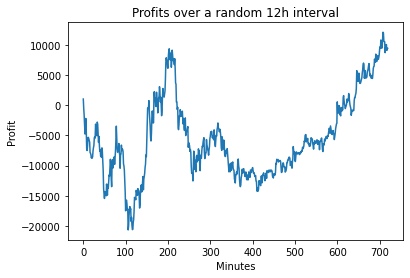

In [27]:
plt.figure()
plt.plot(np.cumsum(rewards))
plt.title("Profits over a random 12h interval")
plt.xlabel("Minutes")
plt.ylabel("Profit")
plt.show()

In [ ]:
# Define some save data
save_data = {"start_index":start_id}
save_data["rewards"] = rewards
save_data['net_worth'] = net_worth
save_data['actions'] = actions
save_data["shares_held"] = shares_held

In [ ]:
# EXPAND THE DATA WE ARE USING
# TEST ON TESTING DATASET
# PLOT THE RESULTS
# CREATE BUY SELL ANIMATION
# DO A DNN AFTER EVAL IS CREATED